In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"
    smooth=0.1
    
    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))

In [5]:
# class ContrailsDataset(Dataset):
#     def __init__(self, df, transform, mode='train'):
#         self.df = df
#         self.transform = A.Compose(transform)
#         self.mode = mode

#     def __getitem__(self, index):
#         row = self.df.iloc[index]
#         path = row.path
#         record_id = row.record_id
#         npy = fastnumpyio.load(str(path)).astype("float32")

#         if self.mode == 'train':
#             image = npy[..., :-1]
#             label = npy[..., -1]
#             data = self.transform(image=image, mask=label)
#             image = data['image']
#             label = data['mask']
            
#             label=np.where(label>0.5,1-CFG.smooth,CFG.smooth)
#             label = np.expand_dims(label, 0)
#             image = torch.tensor(image)
#             label = torch.tensor(label)
#             return image.float(), label.float()

#         if self.mode == 'test':
#             image = npy
#             data = self.transform(image=image)
#             image = data['image']
#             image = torch.tensor(image)
#             return image.float(), record_id

#     def __len__(self):
#         return len(self.df)

In [6]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

# show_dataset(112, dataset_train)


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 256, 256])
train_mask_shape  : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



# Model

In [7]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [8]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG, CFG.smooth)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 5)]

# Training

In [9]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(100):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        epoch_best=epoch
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
    
    if epoch-epoch_best>=CFG.epochs_patience:
        print('Early Stopping')
        break
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 7.79GB  LR : 1.00E-04  Loss: 0.8056: 100%|██████████| 642/642 
Val Loss: 0.6463: 100%|██████████| 58/58 [00:04<00:00, 12.16it/s]               


FBeta : 0.5242	thresh : 0.61	SAVED MODEL



Epoch 1/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.5310: 100%|██████████| 642/642 
Val Loss: 0.5857: 100%|██████████| 58/58 [00:03<00:00, 14.82it/s]               


FBeta : 0.4607	thresh : 0.96



Epoch 2/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4951: 100%|██████████| 642/642 
Val Loss: 0.5737: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.4767	thresh : 0.96



Epoch 3/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4802: 100%|██████████| 642/642 
Val Loss: 0.5028: 100%|██████████| 58/58 [00:03<00:00, 14.85it/s]               


FBeta : 0.5403	thresh : 0.06	SAVED MODEL



Epoch 4/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4723: 100%|██████████| 642/642 
Val Loss: 0.4641: 100%|██████████| 58/58 [00:03<00:00, 14.96it/s]               


FBeta : 0.5664	thresh : 0.81	SAVED MODEL



Epoch 5/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4666: 100%|██████████| 642/642 
Val Loss: 0.4762: 100%|██████████| 58/58 [00:03<00:00, 14.83it/s]               


FBeta : 0.5587	thresh : 0.26



Epoch 6/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4614: 100%|██████████| 642/642 
Val Loss: 0.4905: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s]               


FBeta : 0.5462	thresh : 0.21



Epoch 7/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4607: 100%|██████████| 642/642 
Val Loss: 0.4589: 100%|██████████| 58/58 [00:03<00:00, 15.30it/s]               


FBeta : 0.5736	thresh : 0.41	SAVED MODEL



Epoch 8/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4554: 100%|██████████| 642/642 
Val Loss: 0.4686: 100%|██████████| 58/58 [00:03<00:00, 15.23it/s]               


FBeta : 0.5626	thresh : 0.66



Epoch 9/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4550: 100%|██████████| 642/642 
Val Loss: 0.4561: 100%|██████████| 58/58 [00:03<00:00, 15.28it/s]               


FBeta : 0.5749	thresh : 0.01	SAVED MODEL



Epoch 10/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4478: 100%|██████████| 642/642
Val Loss: 0.4517: 100%|██████████| 58/58 [00:03<00:00, 15.12it/s]               


FBeta : 0.5852	thresh : 0.06	SAVED MODEL



Epoch 11/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4479: 100%|██████████| 642/642
Val Loss: 0.4477: 100%|██████████| 58/58 [00:03<00:00, 15.01it/s]               


FBeta : 0.5835	thresh : 0.36



Epoch 12/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4454: 100%|██████████| 642/642
Val Loss: 0.4795: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.5502	thresh : 0.01



Epoch 13/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4414: 100%|██████████| 642/642
Val Loss: 0.4515: 100%|██████████| 58/58 [00:03<00:00, 14.56it/s]               


FBeta : 0.5757	thresh : 0.06



Epoch 14/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4423: 100%|██████████| 642/642
Val Loss: 0.4526: 100%|██████████| 58/58 [00:04<00:00, 14.46it/s]               


FBeta : 0.5785	thresh : 0.96



Epoch 15/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4371: 100%|██████████| 642/642
Val Loss: 0.4386: 100%|██████████| 58/58 [00:03<00:00, 14.63it/s]               


FBeta : 0.5910	thresh : 0.06	SAVED MODEL



Epoch 16/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4354: 100%|██████████| 642/642
Val Loss: 0.4496: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.5832	thresh : 0.06



Epoch 17/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4370: 100%|██████████| 642/642
Val Loss: 0.4346: 100%|██████████| 58/58 [00:03<00:00, 14.81it/s]               


FBeta : 0.5934	thresh : 0.31	SAVED MODEL



Epoch 18/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4332: 100%|██████████| 642/642
Val Loss: 0.4241: 100%|██████████| 58/58 [00:03<00:00, 14.55it/s]               


FBeta : 0.6050	thresh : 0.91	SAVED MODEL



Epoch 19/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4314: 100%|██████████| 642/642
Val Loss: 0.4298: 100%|██████████| 58/58 [00:03<00:00, 14.68it/s]               


FBeta : 0.5992	thresh : 0.81



Epoch 20/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4325: 100%|██████████| 642/642
Val Loss: 0.4360: 100%|██████████| 58/58 [00:03<00:00, 14.72it/s]               


FBeta : 0.5914	thresh : 0.61



Epoch 21/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4301: 100%|██████████| 642/642
Val Loss: 0.4294: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6017	thresh : 0.96



Epoch 22/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4259: 100%|██████████| 642/642
Val Loss: 0.4420: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.5894	thresh : 0.96



Epoch 23/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4272: 100%|██████████| 642/642
Val Loss: 0.4165: 100%|██████████| 58/58 [00:03<00:00, 14.86it/s]               


FBeta : 0.6102	thresh : 0.46	SAVED MODEL



Epoch 24/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4269: 100%|██████████| 642/642
Val Loss: 0.4304: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6011	thresh : 0.96



Epoch 25/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4254: 100%|██████████| 642/642
Val Loss: 0.4280: 100%|██████████| 58/58 [00:03<00:00, 14.86it/s]               


FBeta : 0.5999	thresh : 0.06



Epoch 26/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4191: 100%|██████████| 642/642
Val Loss: 0.4169: 100%|██████████| 58/58 [00:04<00:00, 13.25it/s]               


FBeta : 0.6064	thresh : 0.61



Epoch 27/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4220: 100%|██████████| 642/642
Val Loss: 0.4331: 100%|██████████| 58/58 [00:03<00:00, 14.81it/s]               


FBeta : 0.5978	thresh : 0.16



Epoch 28/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4207: 100%|██████████| 642/642
Val Loss: 0.4332: 100%|██████████| 58/58 [00:03<00:00, 14.71it/s]               


FBeta : 0.5976	thresh : 0.01



Epoch 29/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4202: 100%|██████████| 642/642
Val Loss: 0.4187: 100%|██████████| 58/58 [00:03<00:00, 14.54it/s]               


FBeta : 0.6085	thresh : 0.26



Epoch 30/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4192: 100%|██████████| 642/642
Val Loss: 0.4230: 100%|██████████| 58/58 [00:03<00:00, 14.55it/s]               


FBeta : 0.6035	thresh : 0.11



Epoch 31/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4139: 100%|██████████| 642/642
Val Loss: 0.4188: 100%|██████████| 58/58 [00:03<00:00, 14.78it/s]               


FBeta : 0.6074	thresh : 0.76



Epoch 32/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4159: 100%|██████████| 642/642
Val Loss: 0.4061: 100%|██████████| 58/58 [00:03<00:00, 15.08it/s]               


FBeta : 0.6235	thresh : 0.96	SAVED MODEL



Epoch 33/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4143: 100%|██████████| 642/642
Val Loss: 0.4122: 100%|██████████| 58/58 [00:03<00:00, 15.11it/s]               


FBeta : 0.6171	thresh : 0.96



Epoch 34/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4143: 100%|██████████| 642/642
Val Loss: 0.4248: 100%|██████████| 58/58 [00:03<00:00, 14.60it/s]               


FBeta : 0.6071	thresh : 0.91



Epoch 35/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4135: 100%|██████████| 642/642
Val Loss: 0.4111: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.6141	thresh : 0.96



Epoch 36/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4120: 100%|██████████| 642/642
Val Loss: 0.4086: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.6197	thresh : 0.01



Epoch 37/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4111: 100%|██████████| 642/642
Val Loss: 0.4189: 100%|██████████| 58/58 [00:03<00:00, 14.95it/s]               


FBeta : 0.6142	thresh : 0.01



Epoch 38/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4111: 100%|██████████| 642/642
Val Loss: 0.4087: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6179	thresh : 0.31



Epoch 39/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4068: 100%|██████████| 642/642
Val Loss: 0.4052: 100%|██████████| 58/58 [00:03<00:00, 14.96it/s]               


FBeta : 0.6221	thresh : 0.11



Epoch 40/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4055: 100%|██████████| 642/642
Val Loss: 0.4135: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s]               


FBeta : 0.6145	thresh : 0.71



Epoch 41/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4060: 100%|██████████| 642/642
Val Loss: 0.4228: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6066	thresh : 0.01



Epoch 42/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4060: 100%|██████████| 642/642
Val Loss: 0.4040: 100%|██████████| 58/58 [00:04<00:00, 11.71it/s]               


FBeta : 0.6204	thresh : 0.06



Epoch 43/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4045: 100%|██████████| 642/642
Val Loss: 0.4036: 100%|██████████| 58/58 [00:03<00:00, 15.29it/s]               


FBeta : 0.6262	thresh : 0.11	SAVED MODEL



Epoch 44/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4027: 100%|██████████| 642/642
Val Loss: 0.4039: 100%|██████████| 58/58 [00:03<00:00, 15.18it/s]               


FBeta : 0.6238	thresh : 0.96



Epoch 45/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4045: 100%|██████████| 642/642
Val Loss: 0.3984: 100%|██████████| 58/58 [00:03<00:00, 15.13it/s]               


FBeta : 0.6267	thresh : 0.46	SAVED MODEL



Epoch 46/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.4021: 100%|██████████| 642/642
Val Loss: 0.3947: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s]               


FBeta : 0.6318	thresh : 0.61	SAVED MODEL



Epoch 47/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3979: 100%|██████████| 642/642
Val Loss: 0.4021: 100%|██████████| 58/58 [00:03<00:00, 15.36it/s]               


FBeta : 0.6281	thresh : 0.96



Epoch 48/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3992: 100%|██████████| 642/642
Val Loss: 0.4011: 100%|██████████| 58/58 [00:03<00:00, 14.88it/s]               


FBeta : 0.6246	thresh : 0.16



Epoch 49/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3975: 100%|██████████| 642/642
Val Loss: 0.3984: 100%|██████████| 58/58 [00:03<00:00, 15.06it/s]               


FBeta : 0.6277	thresh : 0.06



Epoch 50/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3983: 100%|██████████| 642/642
Val Loss: 0.3958: 100%|██████████| 58/58 [00:04<00:00, 13.94it/s]               


FBeta : 0.6295	thresh : 0.06



Epoch 51/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3966: 100%|██████████| 642/642
Val Loss: 0.3956: 100%|██████████| 58/58 [00:04<00:00, 14.33it/s]               


FBeta : 0.6282	thresh : 0.61



Epoch 52/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3925: 100%|██████████| 642/642
Val Loss: 0.3974: 100%|██████████| 58/58 [00:03<00:00, 14.60it/s]               


FBeta : 0.6302	thresh : 0.06



Epoch 53/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3942: 100%|██████████| 642/642
Val Loss: 0.3969: 100%|██████████| 58/58 [00:03<00:00, 14.65it/s]               


FBeta : 0.6308	thresh : 0.06



Epoch 54/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3941: 100%|██████████| 642/642
Val Loss: 0.3932: 100%|██████████| 58/58 [00:03<00:00, 15.08it/s]               


FBeta : 0.6335	thresh : 0.91	SAVED MODEL



Epoch 55/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3928: 100%|██████████| 642/642
Val Loss: 0.3891: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6357	thresh : 0.16	SAVED MODEL



Epoch 56/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3898: 100%|██████████| 642/642
Val Loss: 0.3922: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6341	thresh : 0.66



Epoch 57/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3882: 100%|██████████| 642/642
Val Loss: 0.3847: 100%|██████████| 58/58 [00:03<00:00, 14.80it/s]               


FBeta : 0.6400	thresh : 0.91	SAVED MODEL



Epoch 58/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3891: 100%|██████████| 642/642
Val Loss: 0.3857: 100%|██████████| 58/58 [00:03<00:00, 14.72it/s]               


FBeta : 0.6366	thresh : 0.21



Epoch 59/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3873: 100%|██████████| 642/642
Val Loss: 0.3830: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6388	thresh : 0.36



Epoch 60/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3873: 100%|██████████| 642/642
Val Loss: 0.3894: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6361	thresh : 0.01



Epoch 61/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3880: 100%|██████████| 642/642
Val Loss: 0.3857: 100%|██████████| 58/58 [00:03<00:00, 14.80it/s]               


FBeta : 0.6394	thresh : 0.46



Epoch 62/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3850: 100%|██████████| 642/642
Val Loss: 0.3853: 100%|██████████| 58/58 [00:04<00:00, 14.47it/s]               


FBeta : 0.6395	thresh : 0.26



Epoch 63/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3832: 100%|██████████| 642/642
Val Loss: 0.3835: 100%|██████████| 58/58 [00:03<00:00, 14.93it/s]               


FBeta : 0.6422	thresh : 0.16	SAVED MODEL



Epoch 64/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3823: 100%|██████████| 642/642
Val Loss: 0.3809: 100%|██████████| 58/58 [00:03<00:00, 14.98it/s]               


FBeta : 0.6445	thresh : 0.01	SAVED MODEL



Epoch 65/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3832: 100%|██████████| 642/642
Val Loss: 0.3802: 100%|██████████| 58/58 [00:03<00:00, 14.83it/s]               


FBeta : 0.6438	thresh : 0.11



Epoch 66/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3815: 100%|██████████| 642/642
Val Loss: 0.3908: 100%|██████████| 58/58 [00:03<00:00, 14.88it/s]               


FBeta : 0.6348	thresh : 0.01



Epoch 67/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3814: 100%|██████████| 642/642
Val Loss: 0.3822: 100%|██████████| 58/58 [00:03<00:00, 14.88it/s]               


FBeta : 0.6433	thresh : 0.01



Epoch 68/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3764: 100%|██████████| 642/642
Val Loss: 0.3825: 100%|██████████| 58/58 [00:03<00:00, 14.86it/s]               


FBeta : 0.6440	thresh : 0.06



Epoch 69/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3780: 100%|██████████| 642/642
Val Loss: 0.3833: 100%|██████████| 58/58 [00:03<00:00, 15.02it/s]               


FBeta : 0.6397	thresh : 0.16



Epoch 70/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3781: 100%|██████████| 642/642
Val Loss: 0.3789: 100%|██████████| 58/58 [00:03<00:00, 14.78it/s]               


FBeta : 0.6453	thresh : 0.11	SAVED MODEL



Epoch 71/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3767: 100%|██████████| 642/642
Val Loss: 0.3816: 100%|██████████| 58/58 [00:03<00:00, 14.87it/s]               


FBeta : 0.6416	thresh : 0.11



Epoch 72/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3772: 100%|██████████| 642/642
Val Loss: 0.3785: 100%|██████████| 58/58 [00:03<00:00, 14.77it/s]               


FBeta : 0.6459	thresh : 0.21	SAVED MODEL



Epoch 73/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3759: 100%|██████████| 642/642
Val Loss: 0.3781: 100%|██████████| 58/58 [00:03<00:00, 14.73it/s]               


FBeta : 0.6458	thresh : 0.21



Epoch 74/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3755: 100%|██████████| 642/642
Val Loss: 0.3859: 100%|██████████| 58/58 [00:03<00:00, 14.97it/s]               


FBeta : 0.6374	thresh : 0.06



Epoch 75/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3749: 100%|██████████| 642/642
Val Loss: 0.3807: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.6453	thresh : 0.16



Epoch 76/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3776: 100%|██████████| 642/642
Val Loss: 0.3838: 100%|██████████| 58/58 [00:03<00:00, 14.82it/s]               


FBeta : 0.6393	thresh : 0.11



Epoch 77/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3735: 100%|██████████| 642/642
Val Loss: 0.3758: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.6462	thresh : 0.06	SAVED MODEL



Epoch 78/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3724: 100%|██████████| 642/642
Val Loss: 0.3780: 100%|██████████| 58/58 [00:03<00:00, 15.01it/s]               


FBeta : 0.6457	thresh : 0.11



Epoch 79/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3731: 100%|██████████| 642/642
Val Loss: 0.3782: 100%|██████████| 58/58 [00:03<00:00, 14.83it/s]               


FBeta : 0.6467	thresh : 0.01	SAVED MODEL



Epoch 80/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3719: 100%|██████████| 642/642
Val Loss: 0.3755: 100%|██████████| 58/58 [00:03<00:00, 14.75it/s]               


FBeta : 0.6474	thresh : 0.01	SAVED MODEL



Epoch 81/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3715: 100%|██████████| 642/642
Val Loss: 0.3753: 100%|██████████| 58/58 [00:03<00:00, 15.03it/s]               


FBeta : 0.6485	thresh : 0.31	SAVED MODEL



Epoch 82/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3722: 100%|██████████| 642/642
Val Loss: 0.3754: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.6481	thresh : 0.21



Epoch 83/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3711: 100%|██████████| 642/642
Val Loss: 0.3766: 100%|██████████| 58/58 [00:03<00:00, 14.90it/s]               


FBeta : 0.6475	thresh : 0.16



Epoch 84/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3717: 100%|██████████| 642/642
Val Loss: 0.3775: 100%|██████████| 58/58 [00:03<00:00, 15.21it/s]               


FBeta : 0.6471	thresh : 0.06



Epoch 85/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3721: 100%|██████████| 642/642
Val Loss: 0.3761: 100%|██████████| 58/58 [00:03<00:00, 15.00it/s]               


FBeta : 0.6480	thresh : 0.11



Epoch 86/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3710: 100%|██████████| 642/642
Val Loss: 0.3767: 100%|██████████| 58/58 [00:03<00:00, 14.96it/s]               


FBeta : 0.6475	thresh : 0.11



Epoch 87/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3704: 100%|██████████| 642/642
Val Loss: 0.3763: 100%|██████████| 58/58 [00:03<00:00, 15.05it/s]               


FBeta : 0.6472	thresh : 0.16



Epoch 88/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3721: 100%|██████████| 642/642
Val Loss: 0.3757: 100%|██████████| 58/58 [00:03<00:00, 15.18it/s]               


FBeta : 0.6480	thresh : 0.11



Epoch 89/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3711: 100%|██████████| 642/642
Val Loss: 0.3758: 100%|██████████| 58/58 [00:03<00:00, 15.13it/s]               


FBeta : 0.6481	thresh : 0.31



Epoch 90/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3704: 100%|██████████| 642/642
Val Loss: 0.3763: 100%|██████████| 58/58 [00:03<00:00, 15.31it/s]               


FBeta : 0.6483	thresh : 0.06



Epoch 91/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3688: 100%|██████████| 642/642
Val Loss: 0.3756: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s]               


FBeta : 0.6483	thresh : 0.16



Epoch 92/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3728: 100%|██████████| 642/642
Val Loss: 0.3757: 100%|██████████| 58/58 [00:03<00:00, 15.34it/s]               


FBeta : 0.6480	thresh : 0.01



Epoch 93/90  Mem : 7.79GB  LR : 1.00E-03  Loss: 0.3714: 100%|██████████| 642/642
Val Loss: 0.3756: 100%|██████████| 58/58 [00:03<00:00, 15.23it/s]               


FBeta : 0.6479	thresh : 0.06

Early Stopping
{"status":200,"message":"ok"}

In [10]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.6485


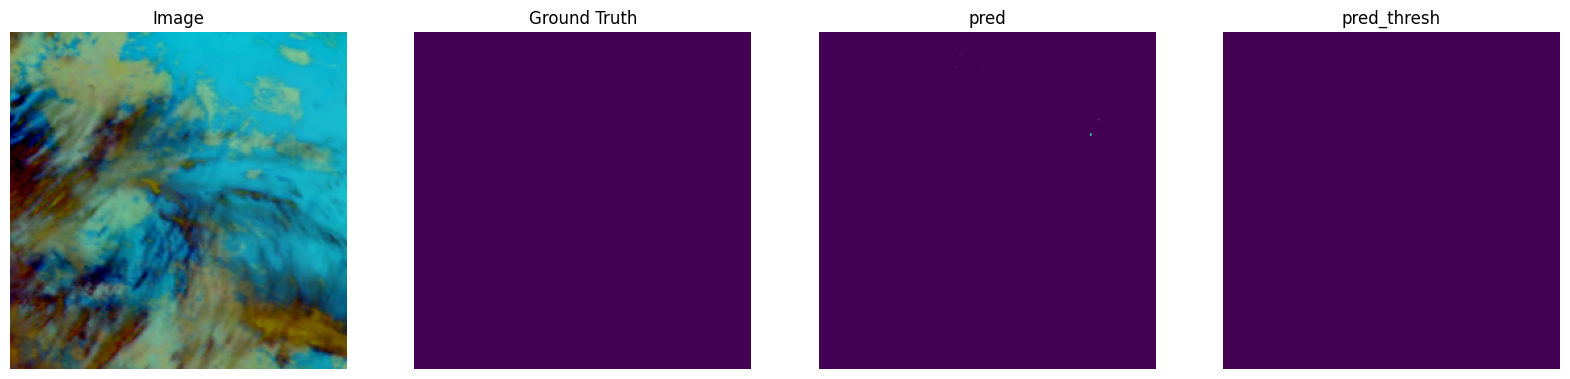

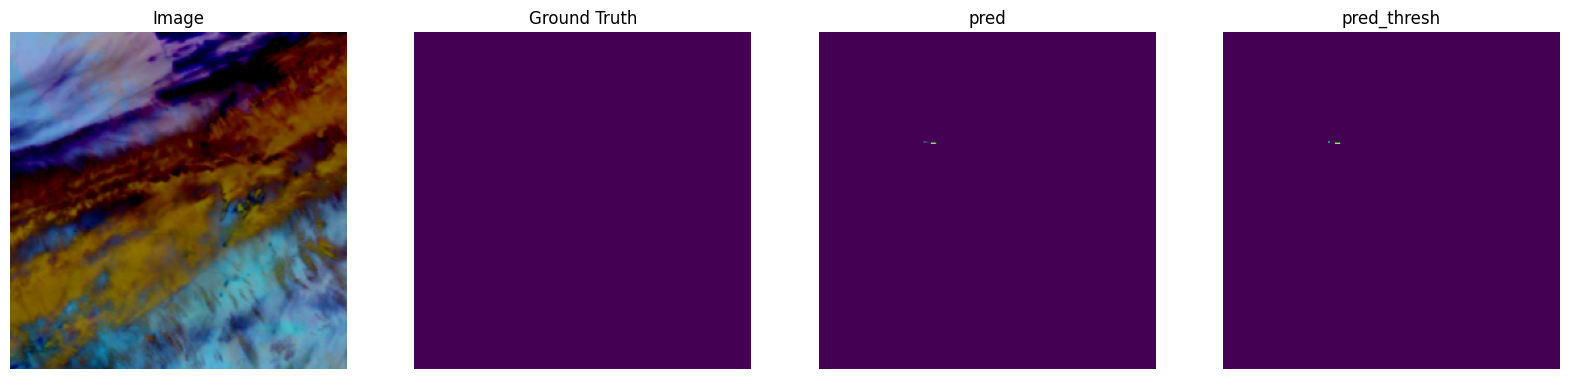

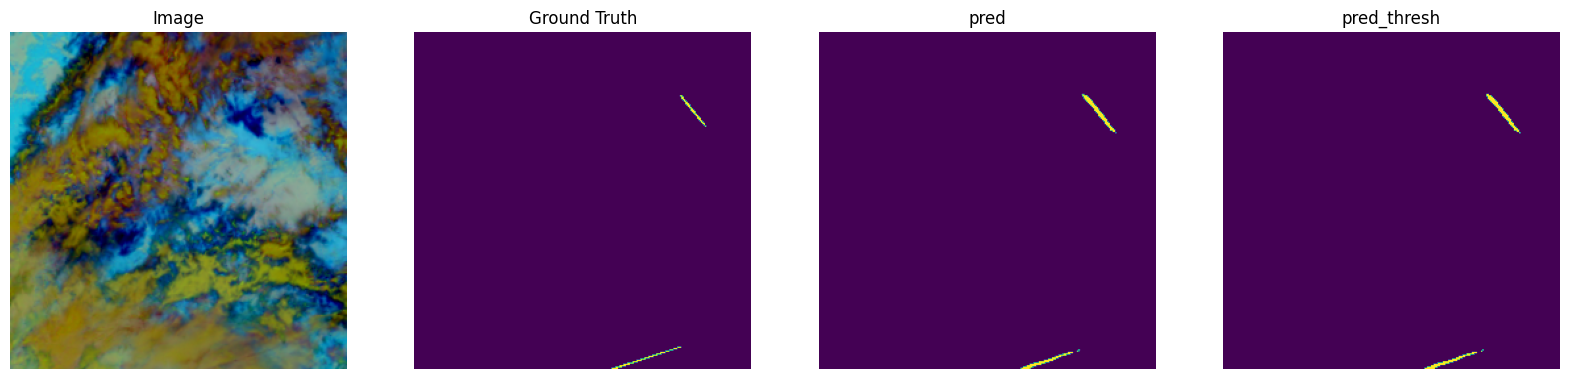

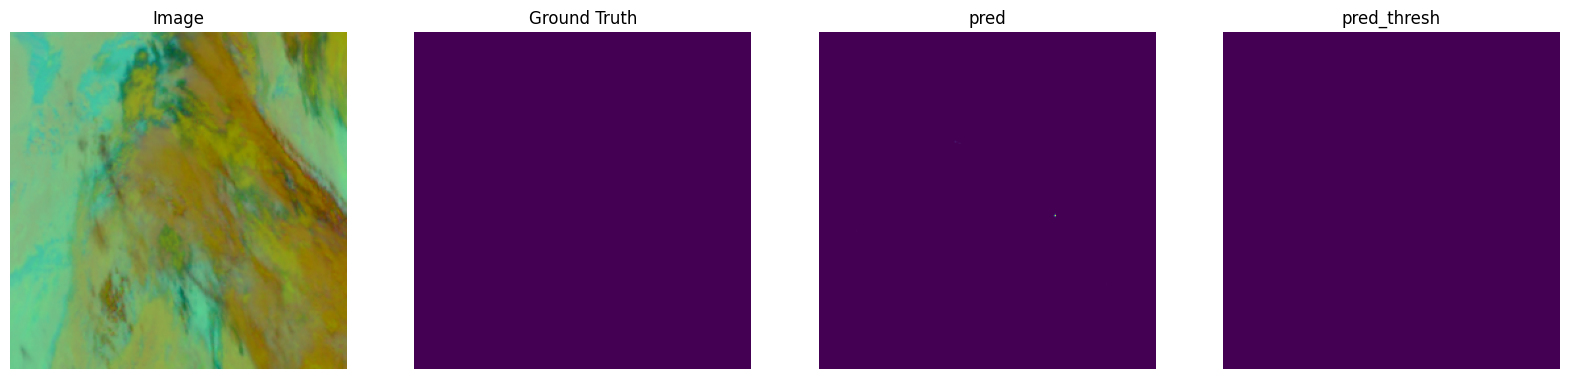

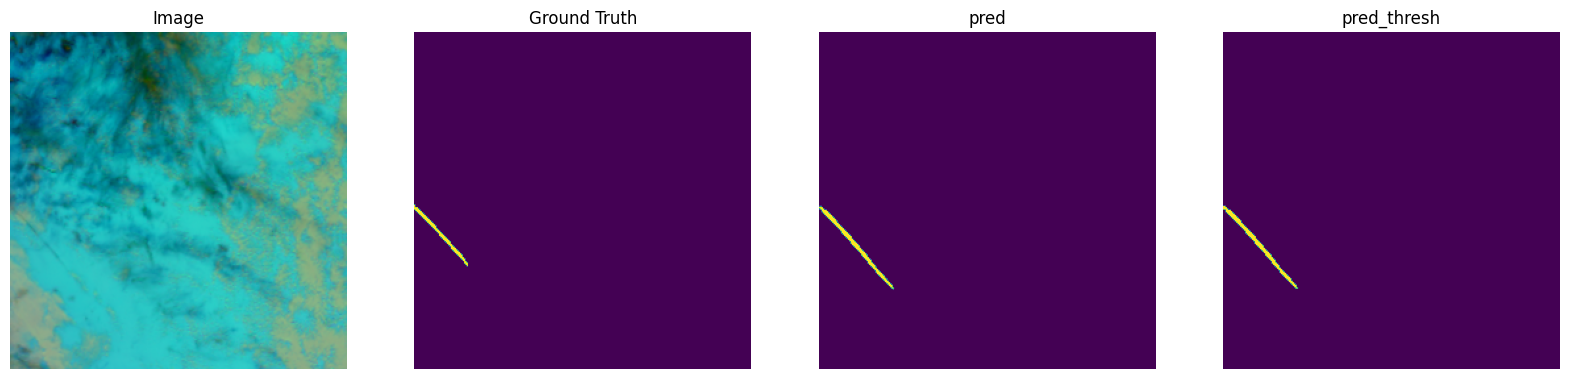

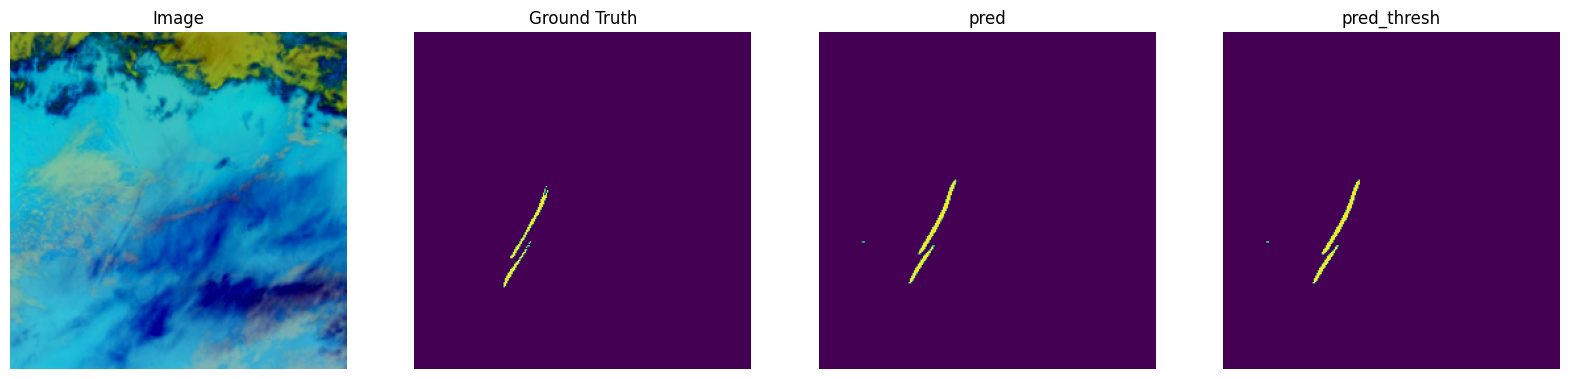

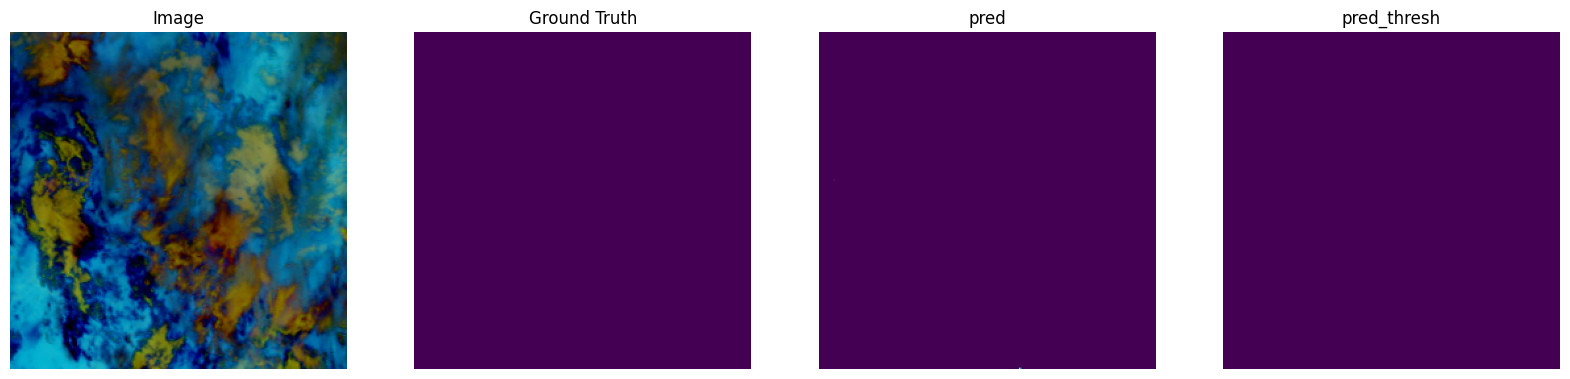

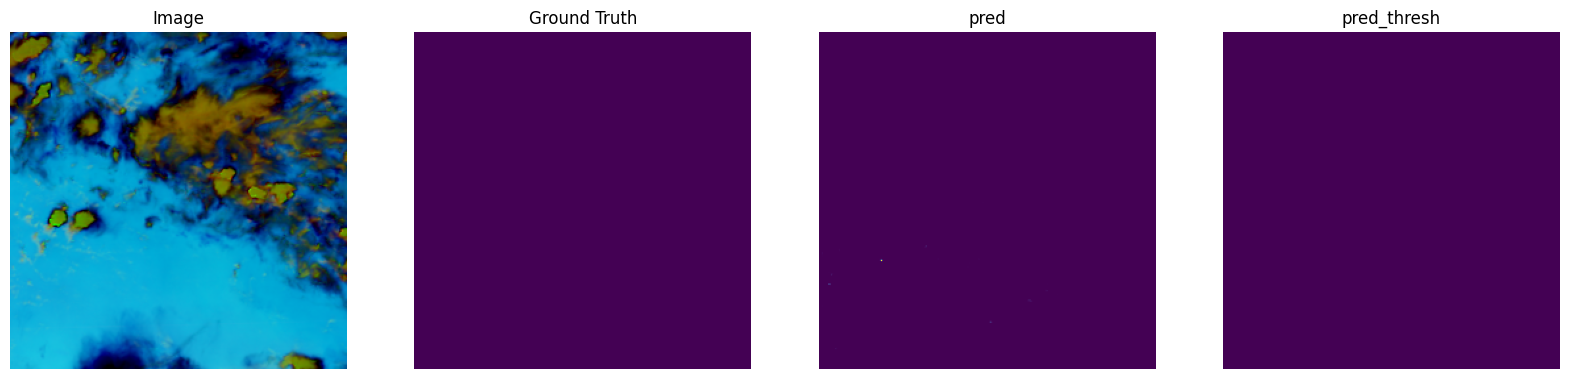

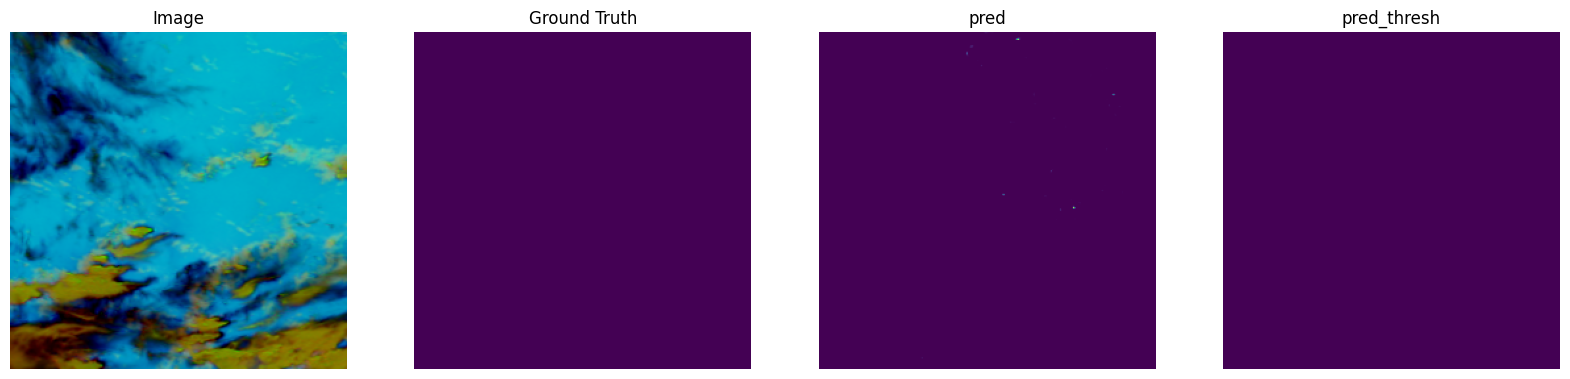

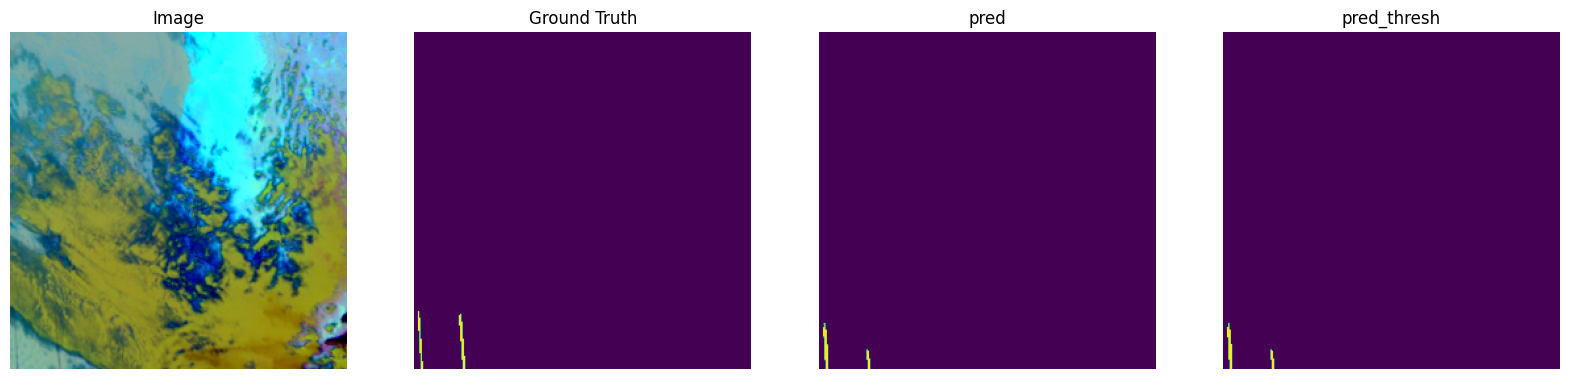

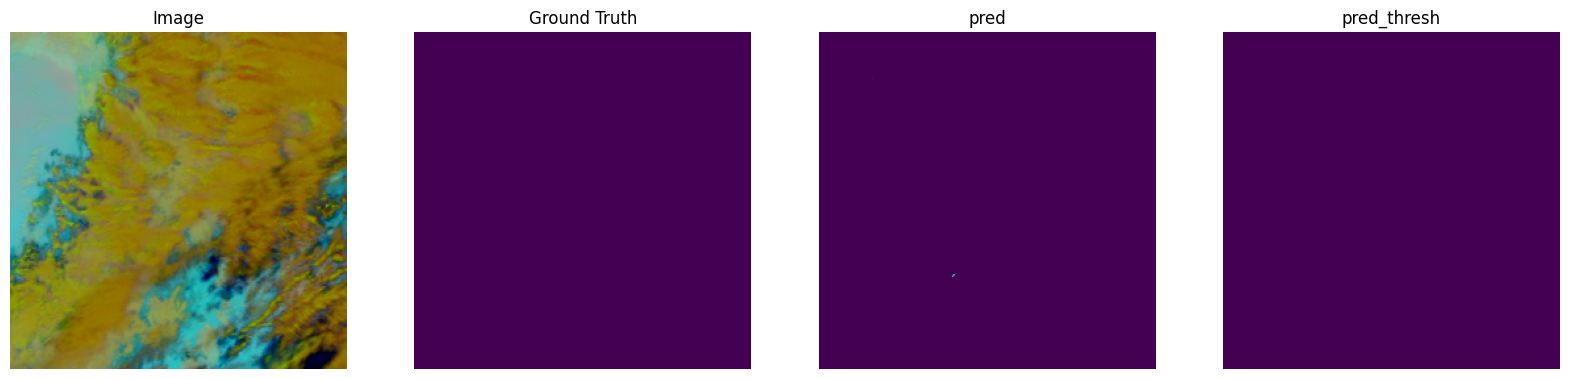

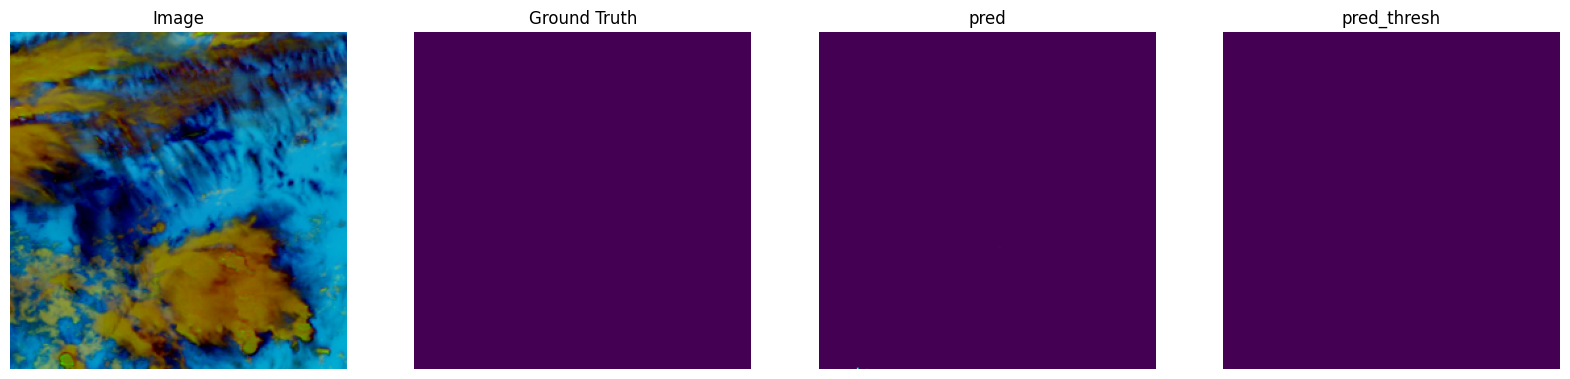

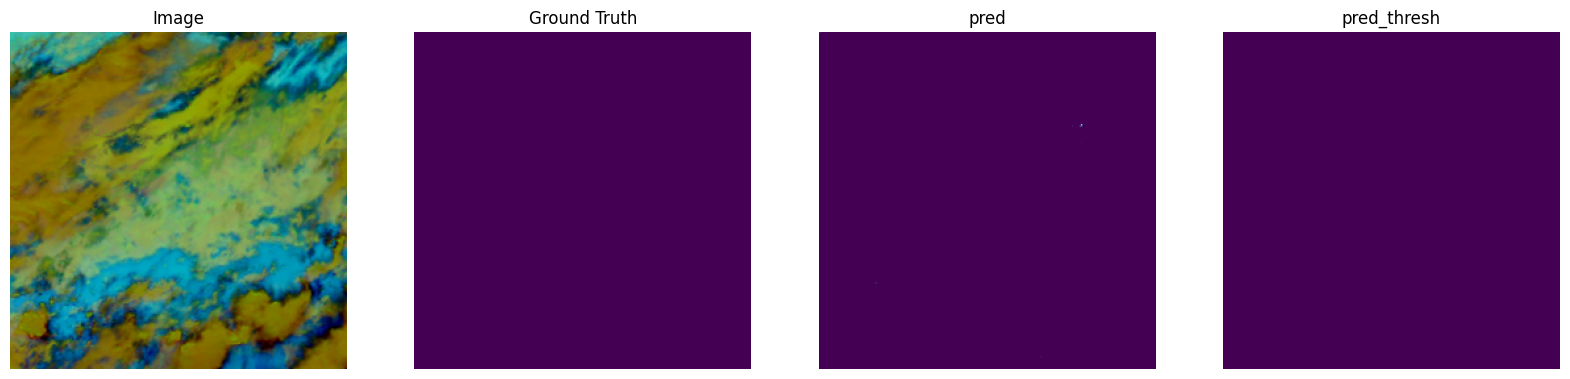

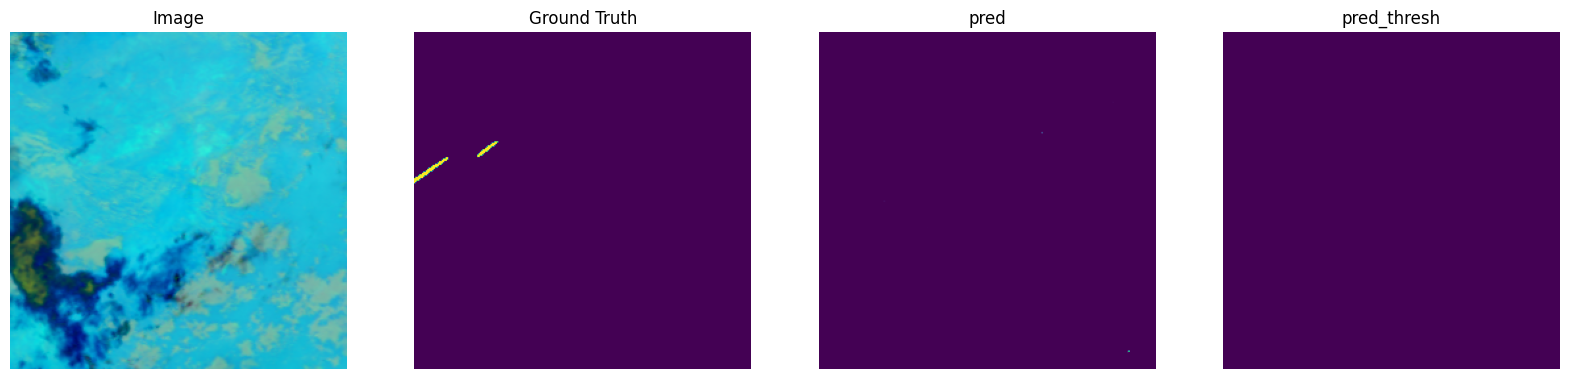

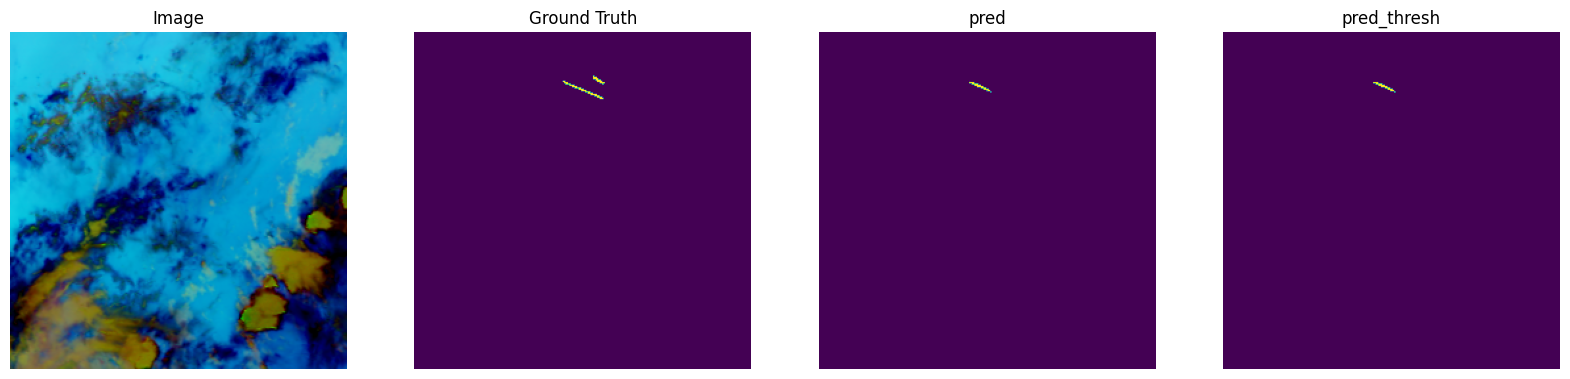

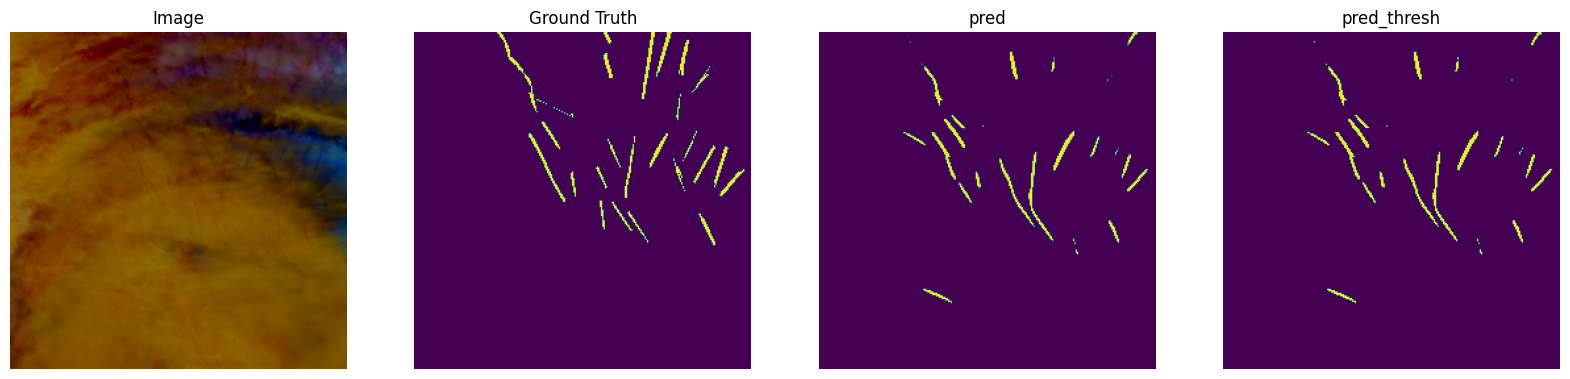

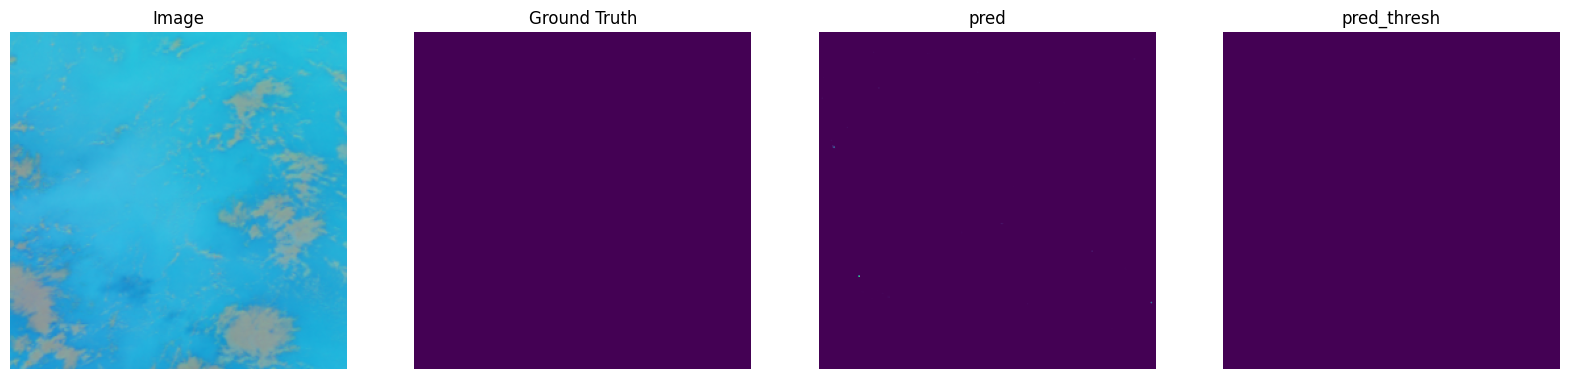

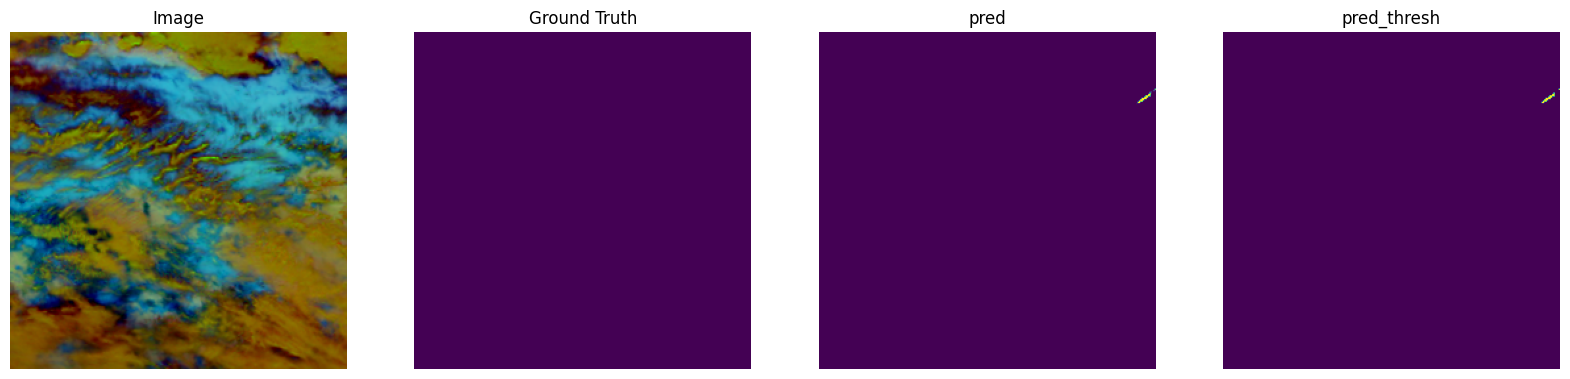

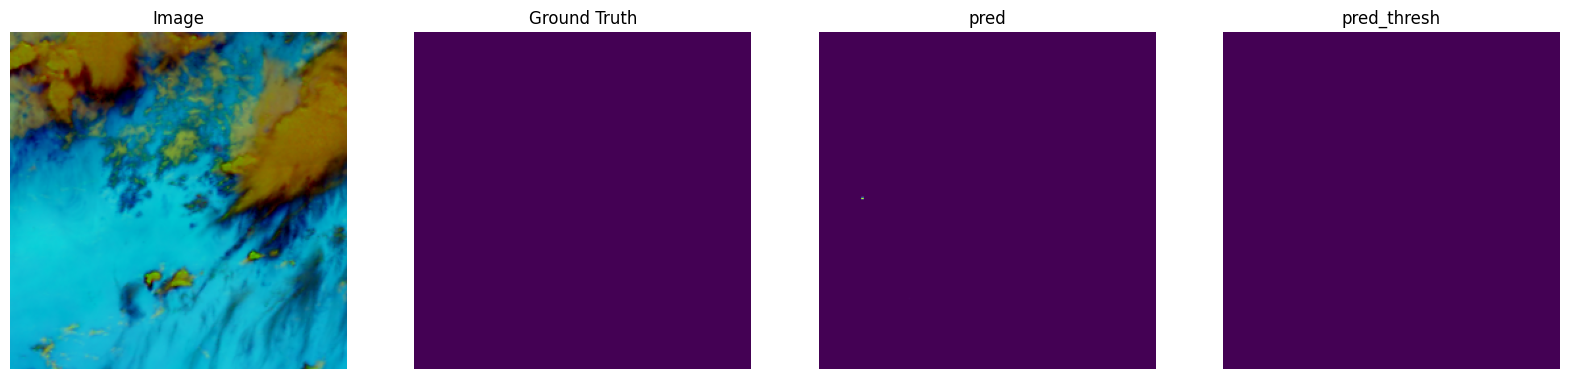

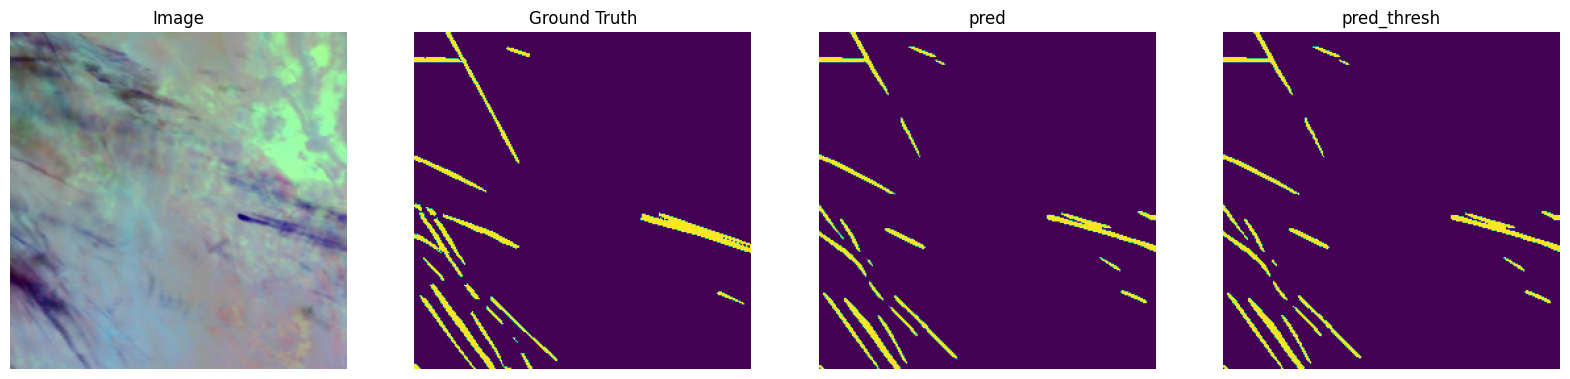

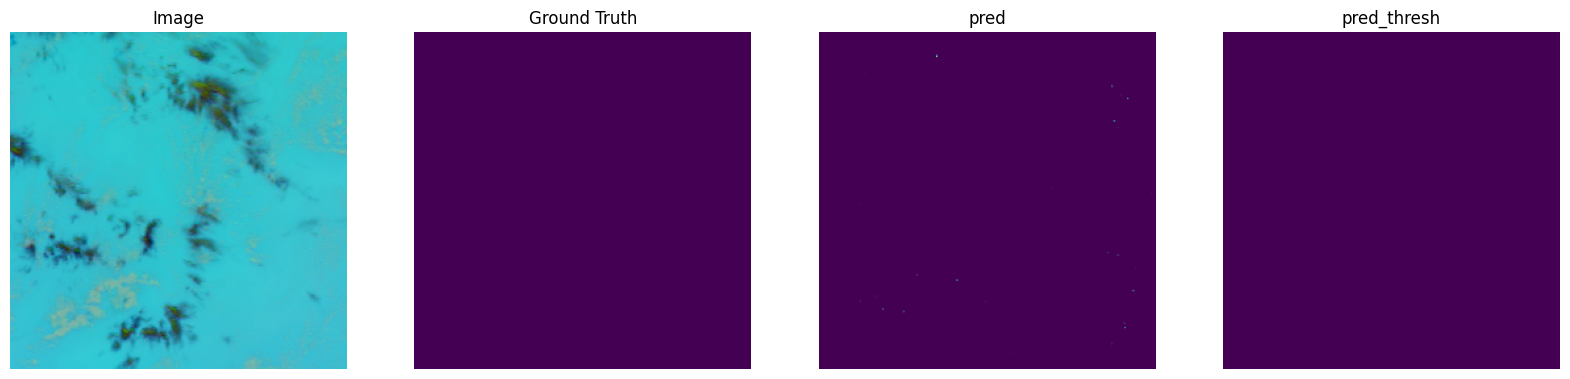

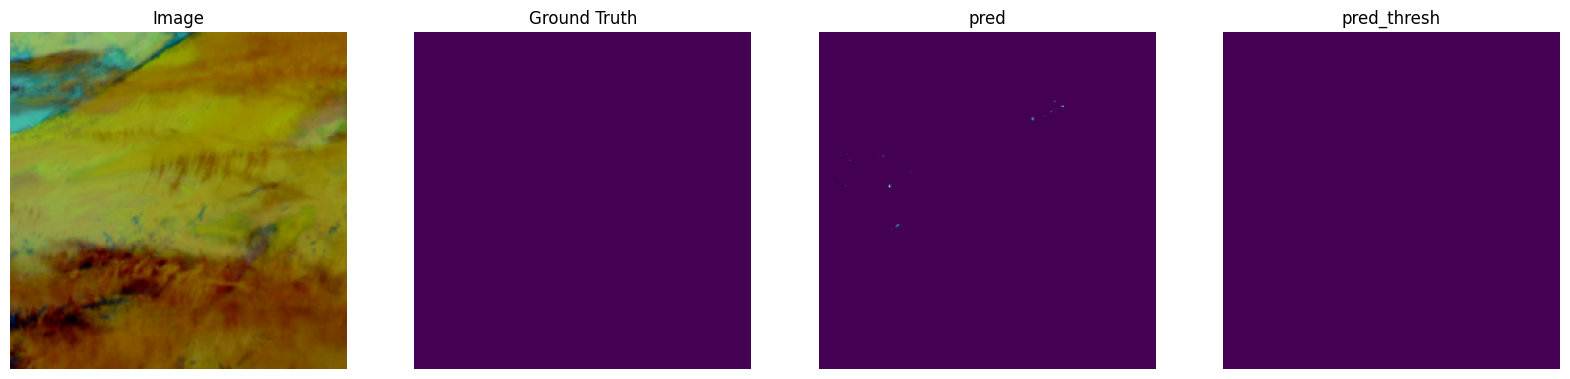

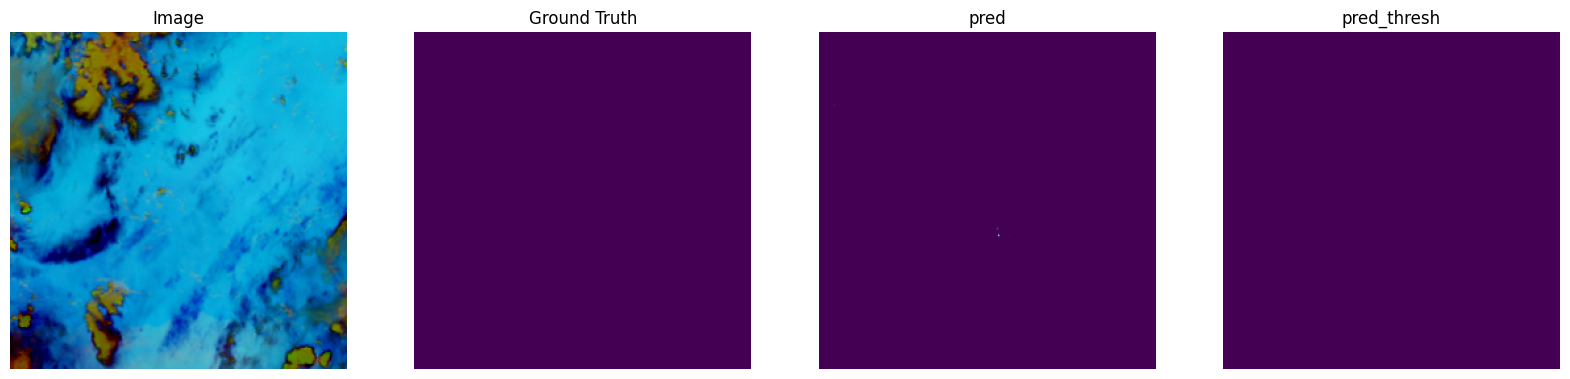

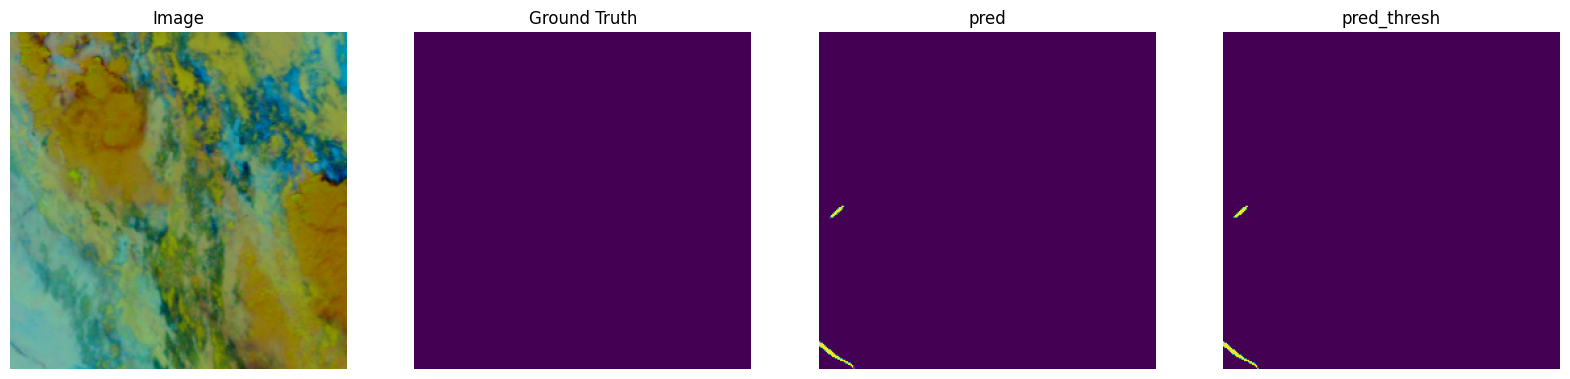

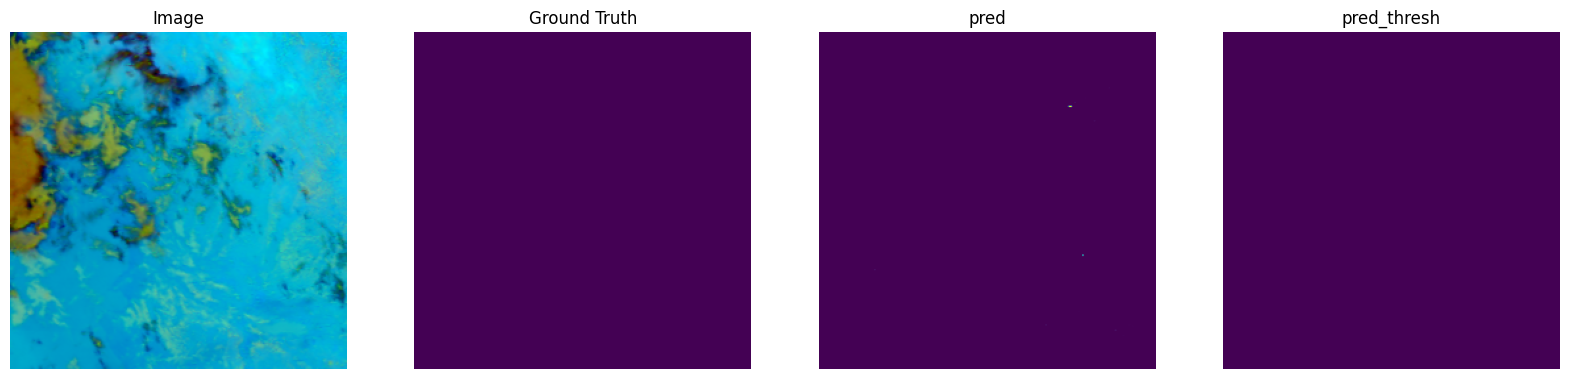

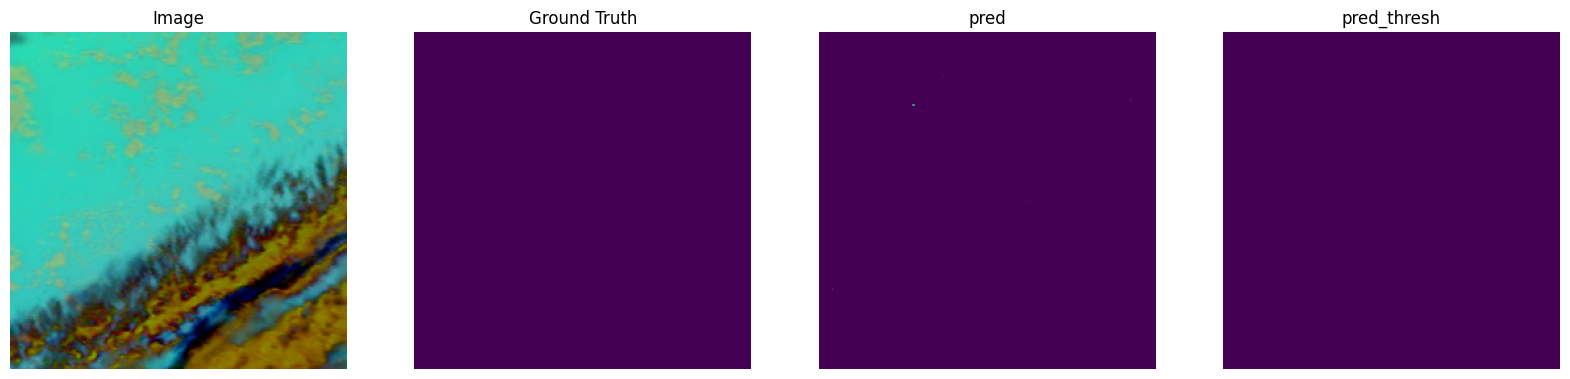

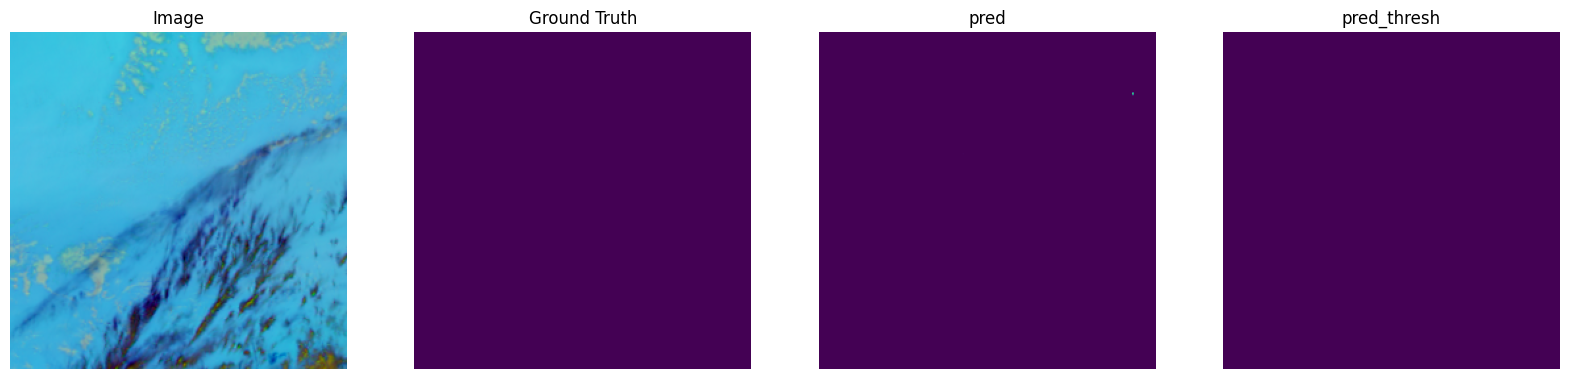

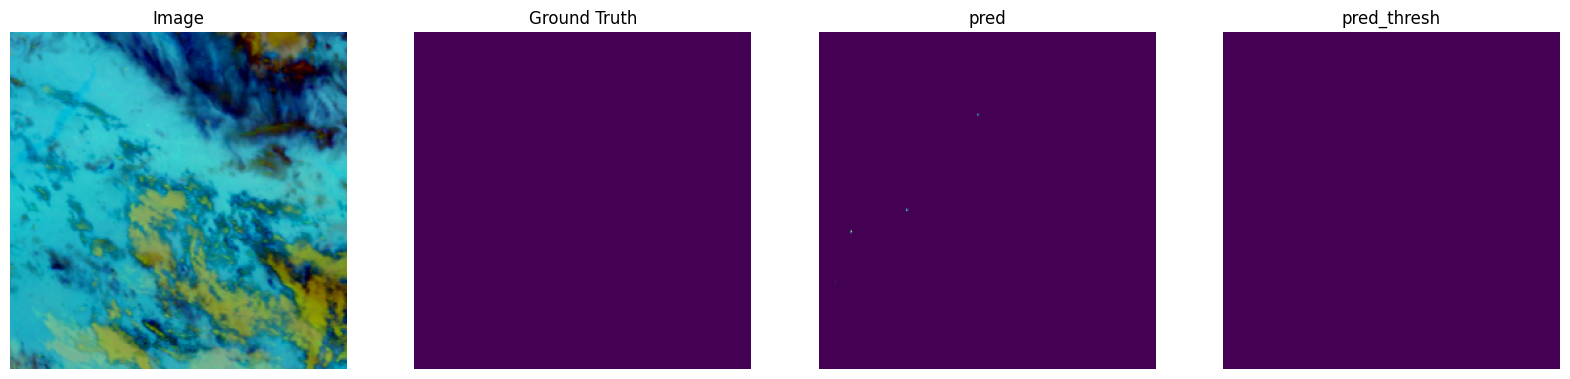

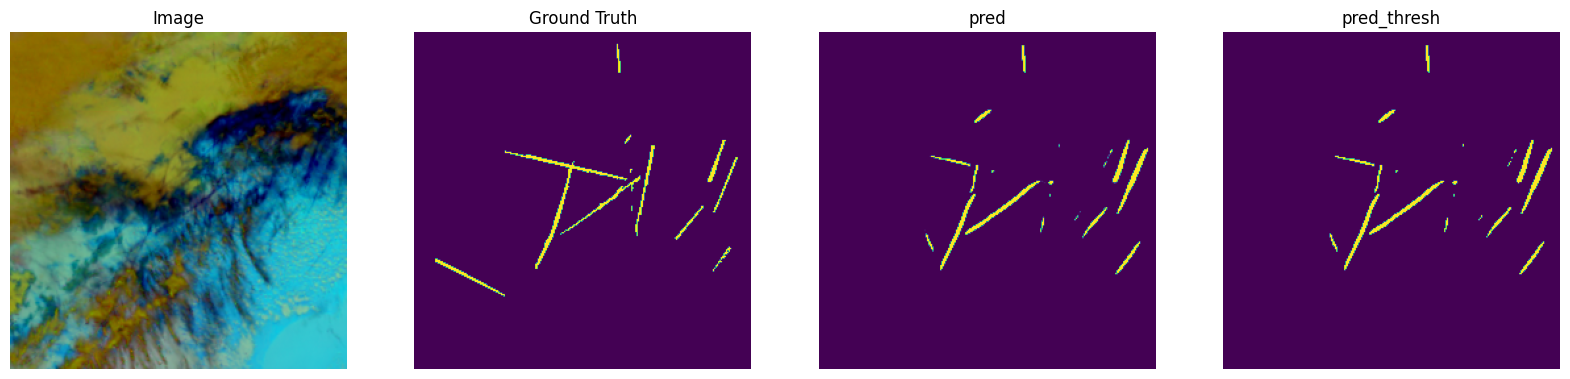

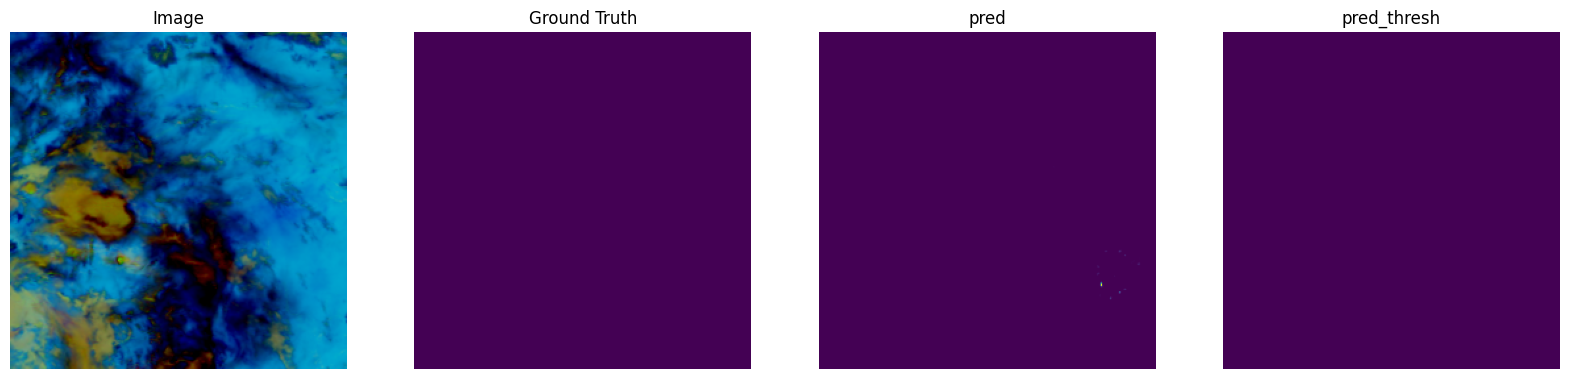

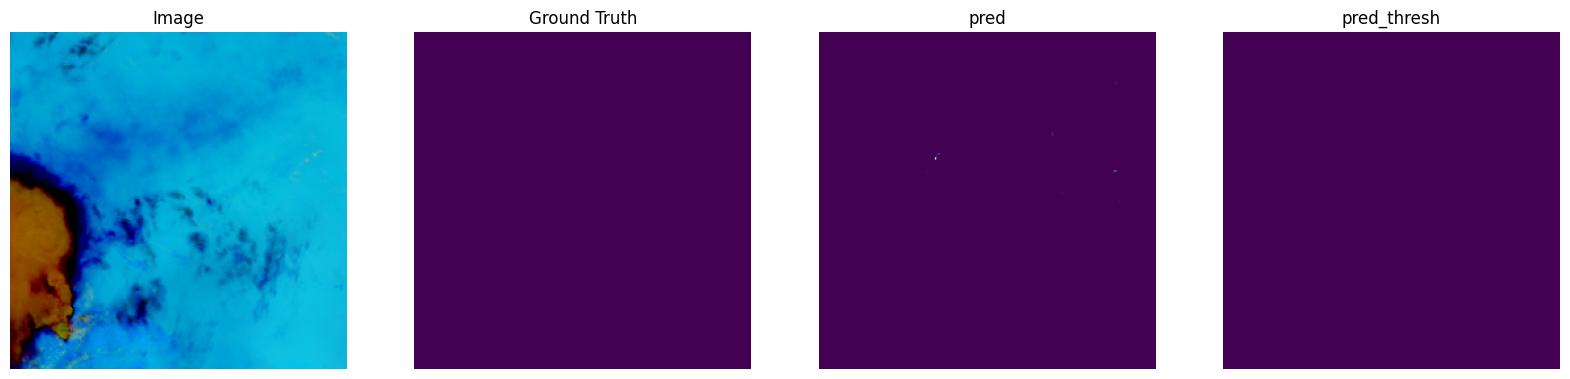

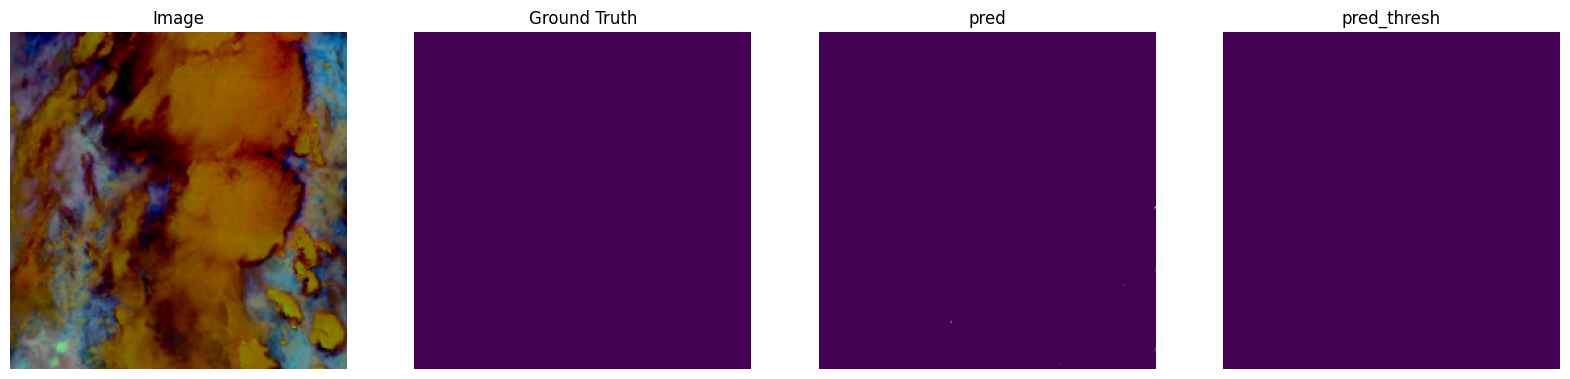

In [11]:
for i, (images, masks) in enumerate(dataloader_valid):
    if i!=1: continue
    
    images, masks = images.cuda(), masks.cuda()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
    images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
    for num in range(CFG.valid_batch_size):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        axes = axes.flatten()
        axes[0].imshow(images[num].permute(1,2,0))
        axes[0].axis('off')
        axes[0].set_title('Image')
        axes[1].imshow(masks[num].permute(1,2,0))
        axes[1].axis('off')
        axes[1].set_title('Ground Truth')
        axes[2].imshow(preds[num].permute(1,2,0))
        axes[2].axis('off')
        axes[2].set_title('pred')
        axes[3].imshow((preds[num]>thresh).permute(1,2,0))
        axes[3].axis('off')
        axes[3].set_title('pred_thresh')
    break